# Multi-Layer Perceptron (MLP): Activations, Losses, and Training

This notebook implements a small MLP from scratch (NumPy) and visualizes:
- Common activation functions and their derivatives
- Binary cross-entropy and mean squared error loss behaviors
- Training an MLP on a simple 2D dataset
- The learned decision boundary

Run the cells top-to-bottom. No external ML libraries required.

In [8]:
# Imports and setup
# We only need NumPy (math on arrays) and Matplotlib (plotting)
import numpy as np
import matplotlib.pyplot as plt

# Make results repeatable every time we run
np.random.seed(42)

# Nice-looking plot style
plt.style.use('seaborn-v0_8-darkgrid')

# Small helper: quickly set common plot labels/titles

def plot_setup(title=None, xlabel=None, ylabel=None):
    if title: plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)


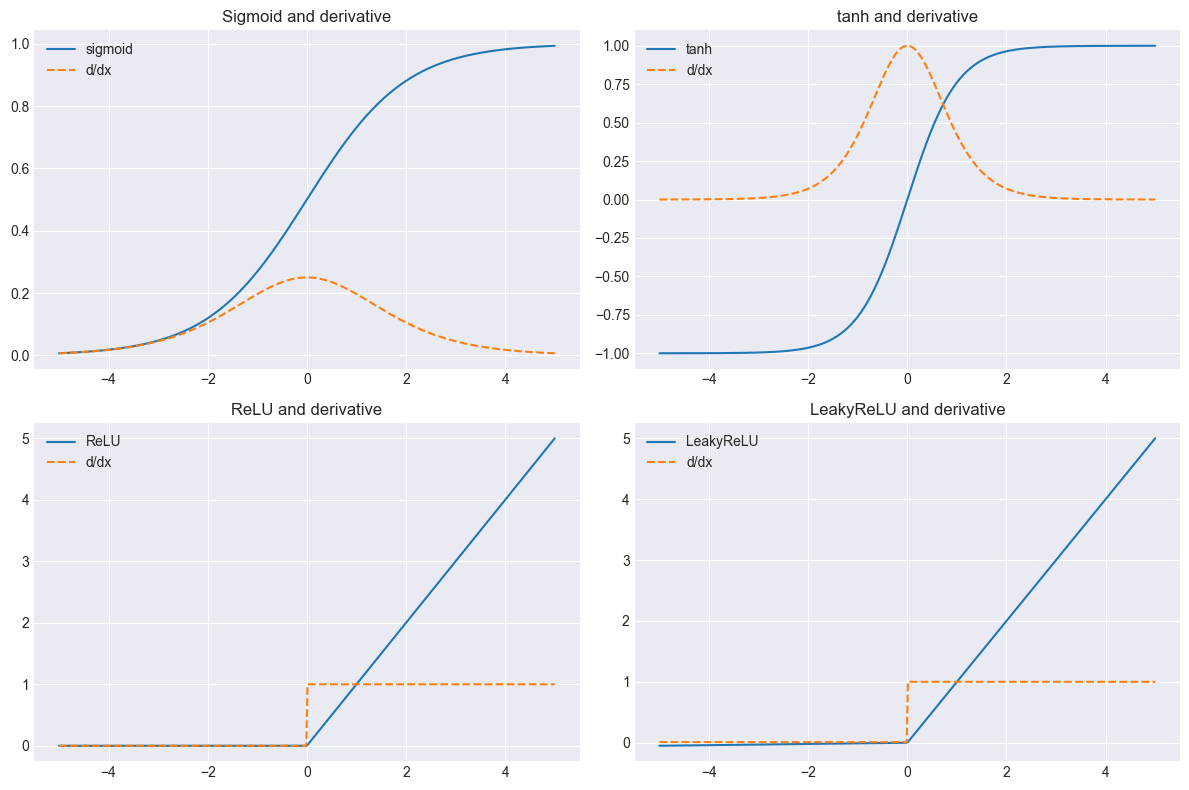

In [9]:
# Activation functions and derivatives
# These functions add non-linearity, letting networks learn curved boundaries.
# The "derivative" tells how much each function changes, needed for learning.

# S-shaped curve between 0 and 1. Good for probabilities.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# How fast sigmoid changes; used in backpropagation.
def dsigmoid(x):
    s = sigmoid(x)
    return s * (s - 1) * -1

# Outputs from -1 to 1, centered at 0.
def tanh(x):
    return np.tanh(x)

# tanh changes fastest around 0; slows at the edges.
def dtanh(x):
    t = np.tanh(x)
    return 1 - t**2

# Keeps positives as-is, turns negatives to 0; simple and popular.
def relu(x):
    return np.maximum(0, x)

# ReLU derivative: 1 when x>0, else 0.
def drelu(x):
    return (x > 0).astype(float)

# Like ReLU but keeps a small slope for negatives to avoid "dead" neurons.
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

# Derivative of Leaky ReLU: small slope on the left, 1 on the right.
def dleaky_relu(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

# Draw the activation curves and how fast they change (their derivatives)
x = np.linspace(-5, 5, 400)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(x, sigmoid(x), label='sigmoid')
axes[0, 0].plot(x, dsigmoid(x), '--', label="d/dx")
axes[0, 0].set_title('Sigmoid and derivative'); axes[0, 0].legend()

axes[0, 1].plot(x, tanh(x), label='tanh')
axes[0, 1].plot(x, dtanh(x), '--', label="d/dx")
axes[0, 1].set_title('tanh and derivative'); axes[0, 1].legend()

axes[1, 0].plot(x, relu(x), label='ReLU')
axes[1, 0].plot(x, drelu(x), '--', label="d/dx")
axes[1, 0].set_title('ReLU and derivative'); axes[1, 0].legend()

axes[1, 1].plot(x, leaky_relu(x), label='LeakyReLU')
axes[1, 1].plot(x, dleaky_relu(x), '--', label="d/dx")
axes[1, 1].set_title('LeakyReLU and derivative'); axes[1, 1].legend()

plt.tight_layout(); plt.show()


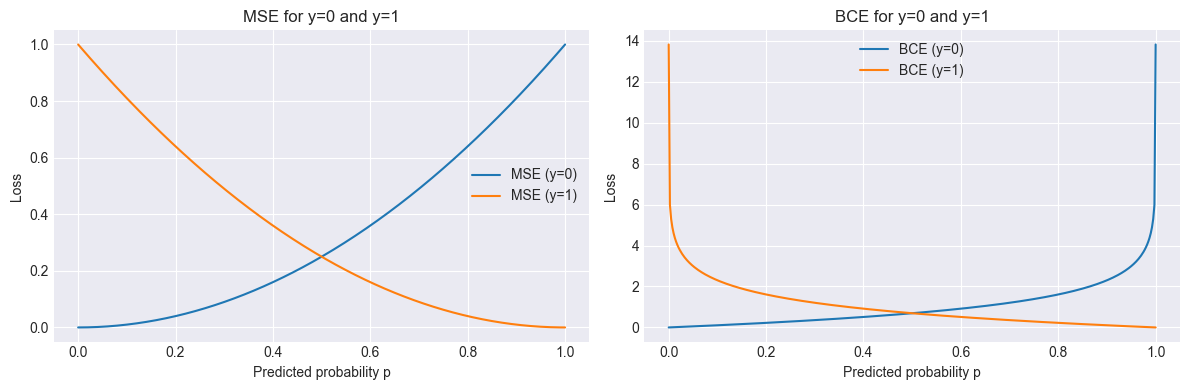

In [10]:
# Loss functions: MSE and Binary Cross-Entropy (BCE)
# A loss tells us how bad our predictions are. Lower is better.
# - MSE (mean squared error): common for regression; also usable for classification but not ideal.
# - BCE (binary cross-entropy): the standard loss for binary classification with probabilities.

# Mean Squared Error: average of squared differences.
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Binary Cross-Entropy: punishes confident wrong guesses very strongly.
# We clip predictions to avoid log(0), which would be infinite.
def bce(y_true, y_pred, eps=1e-12):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Visualize BCE vs MSE for classification: how loss changes as predicted probability p changes
p = np.linspace(1e-6, 1-1e-6, 400)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(p, (0 - p)**2, label='MSE (y=0)')
axes[0].plot(p, (1 - p)**2, label='MSE (y=1)')
axes[0].set_title('MSE for y=0 and y=1'); axes[0].legend(); axes[0].set_xlabel('Predicted probability p'); axes[0].set_ylabel('Loss')

axes[1].plot(p, -np.log(1 - p), label='BCE (y=0)')
axes[1].plot(p, -np.log(p), label='BCE (y=1)')
axes[1].set_title('BCE for y=0 and y=1'); axes[1].legend(); axes[1].set_xlabel('Predicted probability p'); axes[1].set_ylabel('Loss')

plt.tight_layout(); plt.show()


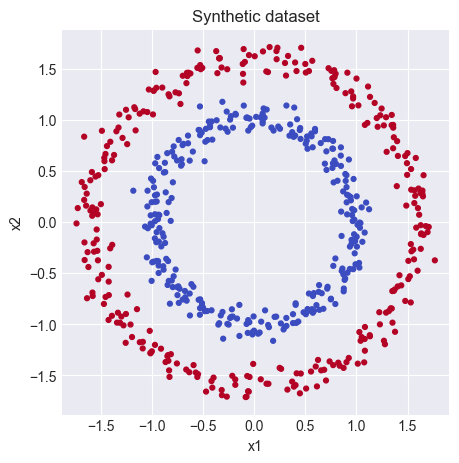

In [11]:
# Generate a simple 2D dataset (two interleaving circles / moons-like)
# We create two rings of points: inner ring = class 0, outer ring = class 1.
# This is a classic dataset that needs non-linear decision boundaries.

def make_rings(n_per_class=200, noise=0.08, radius_inner=1.0, gap=0.5):
    # Angles around the circle for each class
    theta1 = np.linspace(0, 2*np.pi, n_per_class, endpoint=False)
    theta2 = np.linspace(0, 2*np.pi, n_per_class, endpoint=False) + np.pi  # shifted by 180°

    # Radii for inner and outer rings
    r1 = radius_inner
    r2 = radius_inner + gap

    # Convert polar coordinates (r, theta) to Cartesian (x, y) and add noise
    x1 = np.c_[r1*np.cos(theta1), r1*np.sin(theta1)] + noise*np.random.randn(n_per_class, 2)
    x2 = np.c_[r2*np.cos(theta2), r2*np.sin(theta2)] + noise*np.random.randn(n_per_class, 2)

    # Stack data and create labels (0s then 1s)
    X = np.vstack([x1, x2])
    y = np.r_[np.zeros(n_per_class), np.ones(n_per_class)].reshape(-1, 1)
    return X, y

# Build a slightly larger dataset for training
X, y = make_rings(n_per_class=300, noise=0.08, radius_inner=1.0, gap=0.6)

# Quick look at the data
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y.flatten(), cmap='coolwarm', s=12)
plt.title('Synthetic dataset'); plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal')
plt.show()


In [12]:
# Simple MLP with two hidden layers (NumPy)
# This is a tiny neural network built from scratch using basic matrix math.
# It has: input -> hidden layer 1 (ReLU) -> hidden layer 2 (ReLU) -> output (sigmoid)
# We train it using gradient descent on Binary Cross-Entropy loss.

class MLP:
    def __init__(self, input_dim, h1=16, h2=8, lr=0.1, l2=0.0):
        # Learning rate: how big a step we take when updating weights
        self.lr = lr
        # L2 weight decay: small penalty to keep weights from growing too large
        self.l2 = l2

        # Randomly initialize weights; scaling keeps signals from exploding/vanishing
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2 / input_dim)
        self.b1 = np.zeros((1, h1))
        self.W2 = np.random.randn(h1, h2) * np.sqrt(2 / h1)
        self.b2 = np.zeros((1, h2))
        self.W3 = np.random.randn(h2, 1) * np.sqrt(2 / h2)
        self.b3 = np.zeros((1, 1))

    def forward(self, X):
        # Pass data through layers (linear -> activation)
        z1 = X @ self.W1 + self.b1
        a1 = relu(z1)
        z2 = a1 @ self.W2 + self.b2
        a2 = relu(z2)
        z3 = a2 @ self.W3 + self.b3
        # Sigmoid squashes to [0,1] so we can interpret as probability
        yhat = sigmoid(z3)

        # Save values for backpropagation (to compute gradients)
        cache = {"X": X, "z1": z1, "a1": a1, "z2": z2, "a2": a2, "z3": z3, "yhat": yhat}
        return yhat, cache

    def compute_loss(self, y, yhat):
        # Total loss = classification loss + small L2 penalty
        return bce(y, yhat) + 0.5 * self.l2 * (np.sum(self.W1**2) + np.sum(self.W2**2) + np.sum(self.W3**2))

    def backward(self, cache, y):
        # Compute gradients (how to change each weight to reduce loss)
        X, a1, a2, yhat = cache["X"], cache["a1"], cache["a2"], cache["yhat"]
        m = X.shape[0]  # number of samples

        # Derivative of BCE with sigmoid output is (yhat - y)/m (with clipping for safety)
        eps = 1e-12
        yhat_clip = np.clip(yhat, eps, 1 - eps)
        dz3 = (yhat_clip - y) / m
        dW3 = a2.T @ dz3 + self.l2 * self.W3
        db3 = np.sum(dz3, axis=0, keepdims=True)

        # Backprop through ReLU in layer 2
        da2 = dz3 @ self.W3.T
        dz2 = da2 * drelu(cache["z2"])  # zero out where ReLU was off
        dW2 = a1.T @ dz2 + self.l2 * self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # Backprop through ReLU in layer 1
        da1 = dz2 @ self.W2.T
        dz1 = da1 * drelu(cache["z1"])  # zero out where ReLU was off
        dW1 = X.T @ dz1 + self.l2 * self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Update weights by stepping opposite the gradient (SGD)
        self.W3 -= self.lr * dW3; self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2; self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1; self.b1 -= self.lr * db1

    def predict(self, X):
        # Return 0/1 class predictions based on probability threshold 0.5
        yhat, _ = self.forward(X)
        return (yhat >= 0.5).astype(int)


Epoch   50 | loss 0.5618 | val 0.5864 | acc 0.738 | val_acc 0.708
Epoch  100 | loss 0.4284 | val 0.4506 | acc 0.967 | val_acc 0.958
Epoch  150 | loss 0.2594 | val 0.2724 | acc 0.988 | val_acc 1.000
Epoch  200 | loss 0.1346 | val 0.1365 | acc 0.998 | val_acc 1.000
Final Train Acc: 0.998 | Val Acc: 1.000


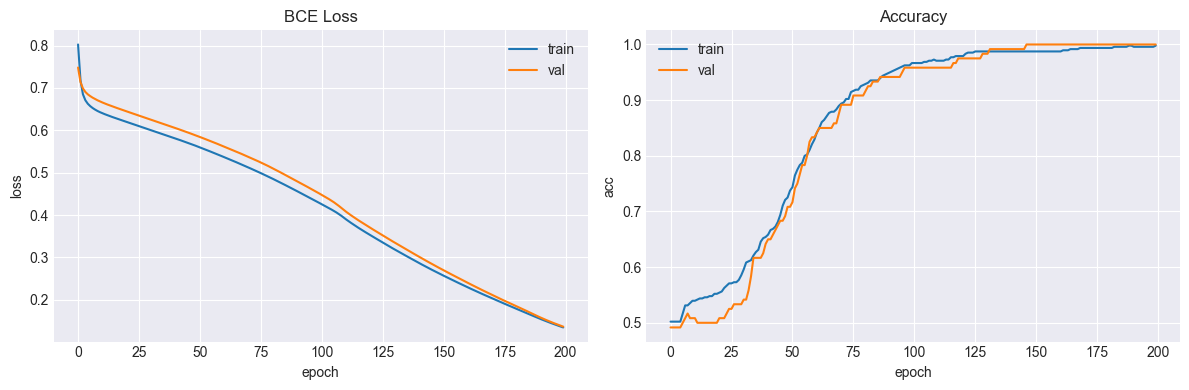

In [13]:
# Train the MLP and plot loss/accuracy
# We split the data into training (learn) and validation (check) parts.

# Train/val split
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8 * len(X))
train_idx, val_idx = idx[:split], idx[split:]
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

# Build the model (try changing sizes or learning rate to see effects)
mlp = MLP(input_dim=2, h1=32, h2=16, lr=0.1, l2=1e-4)

# Train for several passes (epochs) over the data
epochs = 200
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for ep in range(1, epochs + 1):
    # Forward pass: get predictions for current weights
    yhat, cache = mlp.forward(X_train)
    # Compute how wrong we are
    loss = mlp.compute_loss(y_train, yhat)
    # Backward pass: adjust weights to reduce loss
    mlp.backward(cache, y_train)

    # Check performance on validation data (data not used for updating)
    with np.errstate(divide='ignore', invalid='ignore'):
        yhat_val, _ = mlp.forward(X_val)
        vloss = mlp.compute_loss(y_val, yhat_val)

    # Record metrics for plotting later
    train_losses.append(loss)
    val_losses.append(vloss)

    pred_train = (yhat >= 0.5).astype(int)
    pred_val = (yhat_val >= 0.5).astype(int)
    tacc = (pred_train == y_train).mean()
    vacc = (pred_val == y_val).mean()
    train_accs.append(tacc)
    val_accs.append(vacc)

    # Print a progress line every so often
    if ep % 50 == 0:
        print(f"Epoch {ep:4d} | loss {loss:.4f} | val {vloss:.4f} | acc {tacc:.3f} | val_acc {vacc:.3f}")

# Final metrics
print(f"Final Train Acc: {train_accs[-1]:.3f} | Val Acc: {val_accs[-1]:.3f}")

# Plot how loss and accuracy changed over time
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(train_losses, label='train')
axes[0].plot(val_losses, label='val')
axes[0].set_title('BCE Loss'); axes[0].legend(); axes[0].set_xlabel('epoch'); axes[0].set_ylabel('loss')

axes[1].plot(train_accs, label='train')
axes[1].plot(val_accs, label='val')
axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].set_xlabel('epoch'); axes[1].set_ylabel('acc')
plt.tight_layout(); plt.show()


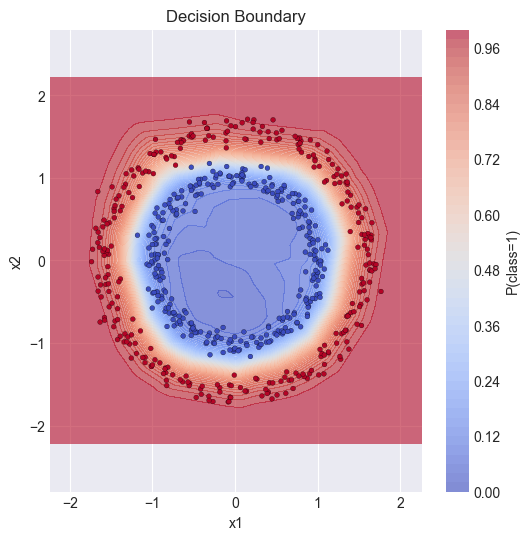

In [14]:
# Decision boundary visualization
# We draw a fine grid over the plot, ask the model for the probability of class 1 at each grid point,
# and color the background by that probability. Then we overlay the original data points.

def plot_decision_boundary(model, X, y, steps=300):
    # Define the bounds of the grid (a bit beyond the data)
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5

    # Create a grid of points to evaluate
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, steps),
        np.linspace(y_min, y_max, steps)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Model probabilities on the grid
    yhat, _ = model.forward(grid)
    Z = yhat.reshape(xx.shape)

    # Plot background as probability and points on top
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label='P(class=1)')
    plt.scatter(X[:,0], X[:,1], c=y.flatten(), cmap='coolwarm', s=12, edgecolor='k', linewidth=0.2)
    plt.title('Decision Boundary'); plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal')
    plt.show()

plot_decision_boundary(mlp, X, y)
